# - 주제

예술가별 예술작품 분류는 이미지 처리 및 머신러닝의 전통적인 접근방식으로 꾸준히 연구되는 주제입니다.

예술작품의 일부분만으로 올바르게 예술가 분류가 가능해야 합니다.

본 프로젝트에서는 DACON 예술작품 화가 분류 AI 경진대회에 참여하여 진행했습니다.

# - 전개 순서
### Ⅰ. 데이터 전처리

DACON AI 경진대회에서 제공하는 이미지 데이터를 사용합니다.

예술가별 작품 개수 분포가 극단적인 형태를 보이기 때문에 데이터 불균형을 해결합니다.

ImageDataGenerator를 활용하여 이미지를 증폭시킵니다.

### Ⅱ. 모델 설계

전이학습 모델을 데이터셋에 맞게 수정하고 개선합니다.

StratifiedKFold와 Noisy Student를 활용하여 모델의 성능을 높입니다.

### Ⅲ. 학습 결과 소프트 보팅

StratifiedKFold에서 지정한 split의 횟수만큼 예측값을 저장합니다.

저장한 예측값을 모두 더하여 soft voting으로 결과를 도출합니다.

# - 라이브러리

In [3]:
# 기본
import numpy as np
import pandas as pd

import os
import glob
import shutil

import math
import random

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# 이미지 수정
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# noisy student
import timm

# sklearn
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR

import torchvision.models as models

# 진행상황 보기
from tqdm.auto import tqdm

# warning 알림 끄기
import warnings
warnings.filterwarnings(action='ignore')

# Ⅰ. 데이터 전처리

In [4]:
train = pd.read_csv('/content/drive/MyDrive/2nd_project/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/2nd_project/data/test.csv')

## 1. 예술가 50명의 작품 개수 확인

In [5]:
train['artist'].value_counts()

Vincent van Gogh             629
Edgar Degas                  490
Pablo Picasso                303
Pierre-Auguste Renoir        233
Albrecht Du rer              220
Paul Gauguin                 220
Francisco Goya               204
Rembrandt                    181
Titian                       173
Marc Chagall                 173
Alfred Sisley                164
Paul Klee                    142
Rene Magritte                137
Amedeo Modigliani            132
Andy Warhol                  132
Henri Matisse                121
Sandro Botticelli            120
Mikhail Vrubel               118
Hieronymus Bosch             115
Leonardo da Vinci            101
Salvador Dali                 99
Peter Paul Rubens             97
Kazimir Malevich              91
Pieter Bruegel                85
Frida Kahlo                   84
Diego Velazquez               81
Joan Miro                     76
Andrei Rublev                 74
Raphael                       73
Giotto di Bondone             72
Gustav Kli

In [6]:
# 예술가별 작품 개수 데이터프레임 생성
df_cnt = train.groupby(['artist'])['id'].count()
df_cnt.sort_values(ascending=False, inplace=True)
df_cnt = pd.DataFrame(df_cnt)
df_cnt.reset_index(inplace=True)
df_cnt.columns = ['artist', 'count']

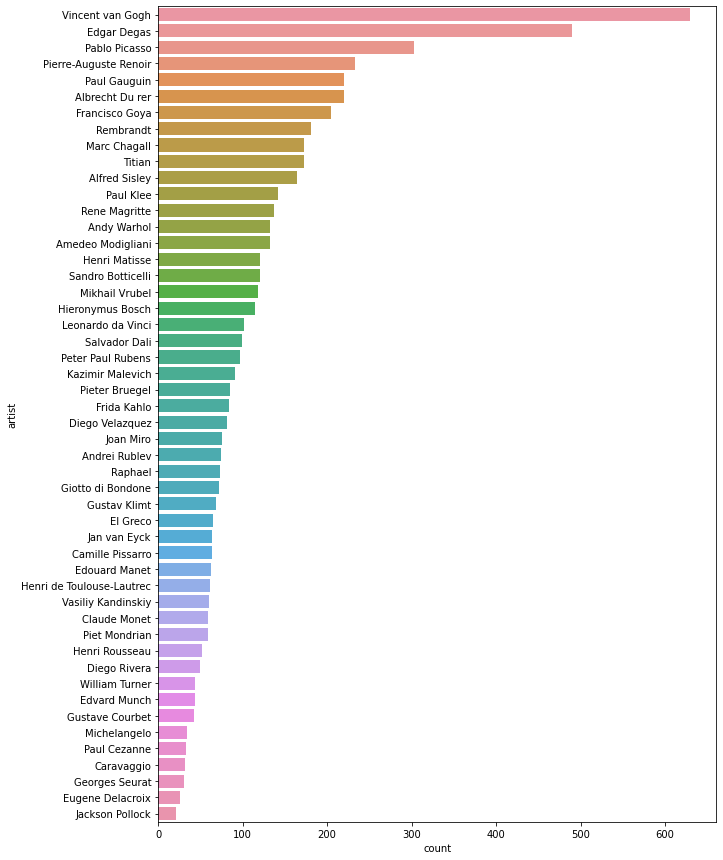

In [7]:
plt.figure(figsize=(10, 15))
sns.barplot(data=df_cnt, x='count', y='artist')
plt.show()

예술가 1명당 약 120개의 예술작품이 분배되어 있는 것이 이상적이지만 데이터를 확인한 결과 매우 불균형하게 분포되어 있습니다.

작품의 개수가 현저하게 적은 예술가의 경우, ImageDataGenerator 활용하여 작품의 개수를 증가시킬 것입니다.

작품의 개수가 평균보다 많은 예술가의 경우, 작품의 개수를 의도적으로 줄일 것입니다.

예술가별 작품 개수의 평균에 가까운 수치인 115를 기준으로 정했습니다.

## 2. 작품 개수의 불균형 해소

### - 리스트 생성

In [8]:
# 작품 개수 115개 이상인 예술가 리스트
over_115 = list(df_cnt['artist'][df_cnt['count'] >= 115])
over_115.sort()

In [9]:
# 작품 개수가 115개 이하인 예술가 리스트
under_115 = list(df_cnt['artist'][df_cnt['count'] < 115])
under_115.sort()

### - 작품 개수가 115개 이상인 예술가

In [10]:
# 예술가별 작품 115개를 추출해서 데이터프레임을 만드는 함수
# file : 데이터를 추출할 데이터프레임
# artist_list : 예술가 리스트
# a, b : 슬라이싱 위치
def DF_slicing(file, artist_list, a, b):
    train_idx = pd.DataFrame()

    for name in artist_list:
        train_idx = pd.concat([train_idx, file.loc[file['artist'] == name].reset_index(drop=True).iloc[a:b]])

    return train_idx

In [11]:
# 작품 개수가 115개 이상인 예술가들의 작품을 115개씩 모아놓은 데이터프레임
train_o115 = DF_slicing(train, over_115, 0, 115)
train_o115['img_path'] = train_o115['img_path'].apply(lambda x:'/content/drive/MyDrive/2nd_project' + x[1:])
train_o115.reset_index(drop=True, inplace=True)
train_o115 = train_o115.iloc[:, 1:]

In [12]:
train_o115.shape

(2185, 2)

In [13]:
train_o115

,img_path,artist
0,/content/drive/MyDrive/2nd_project/train/0042.jpg,Albrecht Du rer
1,/content/drive/MyDrive/2nd_project/train/0054.jpg,Albrecht Du rer
2,/content/drive/MyDrive/2nd_project/train/0058.jpg,Albrecht Du rer
3,/content/drive/MyDrive/2nd_project/train/0077.jpg,Albrecht Du rer
4,/content/drive/MyDrive/2nd_project/train/0094.jpg,Albrecht Du rer
...,...,...
2180,/content/drive/MyDrive/2nd_project/train/1021.jpg,Vincent van Gogh
2181,/content/drive/MyDrive/2nd_project/train/1022.jpg,Vincent van Gogh
2182,/content/drive/MyDrive/2nd_project/train/1025.jpg,Vincent van Gogh
2183,/content/drive/MyDrive/2nd_project/train/1031.jpg,Vincent van Gogh


### - 작품 개수가 115개 이하인 예술가

In [14]:
# 기준 데이터프레임에서 작품 개수가 115개 이하인 예술가들의 작품을 모아놓은 데이터프레임
train_u115 = DF_slicing(train, under_115, 0, 115)
train_u115.reset_index(drop=True, inplace=True)

In [15]:
train_u115.shape

(1904, 3)

분류가 잘 수행되었는지 직접 확인하기 위해 작품 개수가 115개 이하인 예술가들의 폴더를 생성합니다.

→ 예술가별 폴더에 해당 예술가의 작품을 분류합니다.

→ ImageDataGenerator를 활용하여 115개를 기준으로 작품 개수를 증폭시켜서 저장합니다.

→ 증폭된 데이터를 활용하여 작품 개수가 115개 이하인 예술가들의 데이터프레임을 생성합니다.

In [16]:
train_folder = '/content/drive/MyDrive/2nd_project/train/'
files = glob.glob(train_folder + '*.*')

result = []
for file in files:
    result.append(file.replace('\\', '/'))

In [17]:
# 현재 경로를 2nd_project 폴더로 이동
os.chdir('/content/drive/MyDrive/2nd_project/')

# 해당 폴더 밑에 class_buckets 폴더가 없으면 생성
if not os.path.isdir('class_buckets'):
    os.mkdir('class_buckets')
os.chdir('./class_buckets') # 생성한 buckets 폴더로 이동

In [18]:
# 작품의 개수가 115개 이하인 예술가들의 폴더를 생성
for i in range(len(under_115)):
    if not os.path.isdir(under_115[i]):
        os.mkdir(under_115[i])

In [19]:
# 리스트에서 조건에 맞는 파일을 찾으며 다른 폴더로 분류하기
result = list(train_u115['img_path'])

# 현재 경로를 2nd_project로 이동
os.chdir('/content/drive/MyDrive/2nd_project/')

for file in result:  # loop를 돌면서 리스트 안에 데이터를 하나씩 확인
    for j in range(len(train_u115)):
        if file == train_u115['img_path'][j]:
            target_folder = './class_buckets/'
            target_folder += train_u115['artist'][j]
            shutil.copy(file, target_folder)

In [20]:
# 이미지를 생성하여 특정 폴더에 저장하는 함수
def IMG_gen(name, number, n):
    temp = []

    # 이미지의 형태를 변환하며 증폭
    datagen = ImageDataGenerator(rotation_range=50,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 brightness_range=(0.0, 0.9),
                                 shear_range=0.5,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='wrap')

    load_sample = image.load_img(train_u115[train_u115['artist'] == name].reset_index(drop=True)['img_path'][number])
    sample = image.img_to_array(load_sample)
    sample = sample.reshape((1,) + sample.shape)

    # 증폭된 이미지 데이터를 예술가별 폴더에 저장
    i=0
    for batch in datagen.flow(sample,
                              batch_size=1,
                              save_to_dir='/content/drive/MyDrive/2nd_project/class_buckets/' + name,
                              save_prefix=name,
                              save_format='jpg'):
        i += 1
        if i == n:
            break

In [21]:
# 이미지를 예술가별 폴더에 원하는 횟수만큼 증폭하여 저장하는 함수
def IMG_save(target_list, target_df):
    for name in target_list:
        for i in range(len(target_df[target_df['artist'] == name])):
            IMG_gen(name, i, (115 // len(target_df[target_df['artist'] == name])))

In [22]:
# 이미지 증폭 함수 실행
IMG_save(under_115, train_u115)

In [23]:
# 증폭된 이미지 주소와 예술가 이름을 활용하여 train.csv와 같은 형태의 데이터프레임 생성
blank_df = pd.DataFrame(columns = ['img_path', 'artist'])

os.chdir('/content/drive/MyDrive/2nd_project/class_buckets/')

cnt = 0

for i in os.listdir('/content/drive/MyDrive/2nd_project/class_buckets/'):
    for j in os.listdir('/content/drive/MyDrive/2nd_project/class_buckets/' + i):
        blank_df.loc[cnt] = ['/content/drive/MyDrive/2nd_project/class_buckets/' + i + '/' + j, i]
        cnt += 1

blank_df

,img_path,artist
0,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
1,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
2,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
3,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
4,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
...,...,...
4441,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
4442,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
4443,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
4444,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner


In [24]:
# 위의 데이터프레임에서 예술가별 115개의 작품만 추출하여 데이터프레임 형성
train_u115 = DF_slicing(blank_df, under_115, 0, 115)
train_u115

,img_path,artist
0,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
1,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
2,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
3,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
4,/content/drive/MyDrive/2nd_project/class_bucke...,Andrei Rublev
...,...,...
110,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
111,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
112,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
113,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner


## 3. 최종 데이터프레임 생성

In [25]:
# 작품 개수가 115개 이상인 예술가 데이터프레임과 작품 개수가 115개 이하인 예술가 데이터프레임을 병합하여 최종 데이터프레임 생성
df = pd.concat([train_o115, train_u115], axis=0)
df.reset_index(drop=True, inplace=True)
df['id'] = list(range(len(df)))
df = df[['id', 'img_path', 'artist']]
df

,id,img_path,artist
0,0,/content/drive/MyDrive/2nd_project/train/0042.jpg,Albrecht Du rer
1,1,/content/drive/MyDrive/2nd_project/train/0054.jpg,Albrecht Du rer
2,2,/content/drive/MyDrive/2nd_project/train/0058.jpg,Albrecht Du rer
3,3,/content/drive/MyDrive/2nd_project/train/0077.jpg,Albrecht Du rer
4,4,/content/drive/MyDrive/2nd_project/train/0094.jpg,Albrecht Du rer
...,...,...,...
5745,5745,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
5746,5746,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
5747,5747,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner
5748,5748,/content/drive/MyDrive/2nd_project/class_bucke...,William Turner


In [26]:
# 모델 학습 과정에서 train.csv를 대체하여 사용할 수 있도록 csv 파일로 저장
df.to_csv('/content/drive/MyDrive/2nd_project/df.csv', index=False)

# Ⅱ. 모델 설계

## 1. 클래스 및 함수 선언

### - 결과를 재현하기 위한 seed 고정

In [27]:
# seed 고정(random_state=42)
def fixed_seed(seed:int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

fixed_seed(42)

### - cuda 사용 가능 여부 확인(0 : 사용 불가 / 1 : 사용 가능)

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.device_count())

1


In [29]:
# 각종 파라미터의 디폴트값
Default_param = {
    'Img_size' : 224,
    'Epochs' : 50,
    'Learning_rate' : 1e-3,
    'Batch_size' : 16
}

In [30]:
# csv 파일에서 이미지 파일의 주소를 가져오는 함수
def img_data(df, infer=False):

    # 라벨 데이터(화가 이름)가 없는 경우 이미지 파일의 주소만 가져옴 → test.csv
    if infer:
        return df['img_path'].values

    # 라벨 데이터(화가 이름)가 있는 경우 이미지 파일의 주소와 라벨을 모두 가져옴 → train.csv
    return df['img_path'].values, df['artist'].values 

### - 라벨 인코딩 및 이미지 파일 경로 조정

In [31]:
# train 불러오기
df = pd.read_csv('/content/drive/MyDrive/2nd_project/df.csv')

# 라벨 데이터 라벨 인코딩
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

# test 불러오기
test_df = pd.read_csv('/content/drive/MyDrive/2nd_project/data/test.csv')
test_df['img_path'] = test_df['img_path'].apply(lambda x:'/content/drive/MyDrive/2nd_project' + x[1:])
test_img_paths = img_data(test_df, infer=True)

이미지 데이터는 용량이 크기 때문에 한번에 다 불러올 수 없는 문제가 발생합니다.

img_path만을 가지고 있다가 필요할 때만 이 클래스를 통해 미니배치마다 이미지를 cv2로 읽어서 가져옵니다.

In [32]:
# 데이터를 불러오는 클래스
class Load_Dataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths # 이미지 주소
        self.labels = labels # 라벨(화가 이름)
        self.transforms = transforms # albumentation 함수 적용 여부

    # dataloader가 데이터를 가져올 때마다 매번 호출
    def __getitem__(self, index):
        img_path = self.img_paths[index] # index 번호의 이미지 주소를 가져옴
        image = cv2.imread(img_path) # cv2로 읽음
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # rgb 변환

        # albumentaion 함수를 적용할 경우
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        # 라벨 데이터가 있을 경우 이미지와 라벨을 모두 반환
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        
        # 라벨 데이터가 없을 경우 이미지만 반환
        else:
            return image
    
    def __len__(self): # 이미지 개수를 알려주는 내장 함수
        return len(self.img_paths)

### - 모델 설계(EfficientNet_B4)

In [33]:
# 모델을 설계하는 클래스
class Base_Model(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(Base_Model, self).__init__()
        self.backbone = models.efficientnet_b4(pretrained=True) # efficientnet_b4를 사용 → output이 1000개
        self.classifier = nn.Linear(1000, num_classes) # output 1000개를 받아 화가 명수(50명)만큼 출력하도록 함 → tensorflow의 dense층을 추가하는 것과 유사함
        
    def forward(self, x):
        x = self.backbone(x) # 위의 efficientnet_b4 
        x = self.classifier(x) # 위의 Linear
        return x

전이학습에 EfficientNet_B4 모델을 사용했습니다.

EfficientNet_B4 모델은 ResNet 등 다른 모델에 비해 10배 가량 가벼우면서 훨씬 좋은 성능을 보여줍니다.

EfficientNet_B4의 기본 출력은 1000이므로 class가 50인 층을 하나 더 추가하여 데이터에 맞게 수정합니다.

tensorflow의 tf.keras.Model을 상속받은 경우와 유사합니다.

### - 이미지 전처리 함수

In [38]:
# 그림 데이터 분할
def album(train_img_paths, train_labels, val_img_paths, val_labels, test_img_paths):

    # train, validation에 적용
    train_transform = A.Compose(
        [
            A.Resize(p=1, height=224*2, width=224*2), # 224 * 2로 resize → p=1을 통해 100% 확률로 수행
            A.RandomCrop(p=1, height=224, width=224), # 2개로 자름 → p=1을 통해 100% 확률로 수행
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5), # 랜덤으로 이미지에 사각형 구멍을 냄 → p=0.5를 통해 50% 확률로 수행
            A.OneOf([
                                                A.MotionBlur(p=1),
                                                A.OpticalDistortion(p=1),
                                                A.GaussNoise(p=1)
                    ], p= 0.3), # 셋 중 하나 적용
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.3), # 색상에 변화를 줌
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 일종의 scaling → 전부 기본값이라 생략 가능
            ToTensorV2() # torch로 학습할 수 있도록 텐서로 변환
            ])

    # test에 적용, normalize를 제외함
    test_transform = A.Compose(
        [
            A.Resize(height=224, width=224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
            ToTensorV2()
            ])

    # train 데이터 구성하고 가져오는 함수
    train_dataset = Load_Dataset(train_img_paths, train_labels, train_transform)
    train_loader = DataLoader(train_dataset, batch_size=Default_param['Batch_size'], shuffle=True, num_workers=0)

    # val 데이터를 구성하고 가져오는 함수
    val_dataset = Load_Dataset(val_img_paths, val_labels, test_transform)
    val_loader = DataLoader(val_dataset, batch_size=Default_param['Batch_size'], shuffle=False, num_workers=0)

    # test 데이터를 구성하고 가져오는 함수 → test 데이터에는 라벨 데이터(화가 이름)가 없으므로 labels=None
    test_dataset = Load_Dataset(test_img_paths, None, test_transform)
    test_loader = DataLoader(test_dataset, batch_size=Default_param['Batch_size'], shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

#### ① albumentation

이미지를 전처리합니다. ImageDataGenerator와 유사한 기능을 합니다.

train을 위한 데이터에는 학습을 위해 크기 조정, 정규화 외에도 noise, crop(자르기) 등의 효과를 추가합니다.

test를 위한 데이터에는 크기 조정과 정규화만 적용합니다.

#### ② Load_Dataset

가져오는 데이터를 매번 cv2로 읽는 클래스입니다.

#### ③ dataloader

Load_Dataset에서 batch size만큼 데이터를 가져옵니다.

train, validation, test를 위한 세 개의 dataloader를 만들어 반환합니다.

### - train 함수

In [34]:
# 학습을 진행하는 함수
def train(model, optimizer, train_loader, test_loader, scheduler, device, earlystop): 
    model.to(device) 

    # crossentropy
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, Default_param['Epochs'] + 1): # 에포크 수만큼 반복
        model.train() # train 선언, 가중치 갱신 가능

        train_loss = []

        # train_loader로부터 이미지와 라벨을 받아옴
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)

            optimizer.zero_grad() # gradient 0으로 초기화

            model_pred = model(img) # img를 model에 넣은 출력값
            loss = criterion(model_pred, label) # loss 값
            loss.backward() # 역전파

            optimizer.step() # optimizer 갱신

            train_loss.append(loss.item()) # train_loss에 loss값 넣기

        tr_loss = np.mean(train_loss)

        # 아래의 validation 참조
        val_loss, val_score = validation(model, criterion, test_loader, device)

        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')

        # earlystopping 갱신
        earlystop(val_score)

        # scheduler가 있을 경우 scheduler 갱신
        if scheduler is not None:
            scheduler.step()

        # 에포크마다 val_score가 가장 높은 경우를 모델로 선택
        if best_score < val_score:
            best_model = model
            best_score = val_score

        # earlystopping 조건을 만족할 경우 train 종료
        if earlystop.early_stop:
            break

    return best_model

crossentropy를 loss로 사용해서 학습을 진행합니다.

tensorflow와는 다르게 epoch와 미니배치를 for 구문으로 구현합니다.

### - earlystopping 클래스

In [36]:
# earlystopping 클래스
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):

        # 우선 첫번째 score를 best_score로 선정
        if self.best_score is None:
            self.best_score = score

        # 그 다음부터 best_score보다 작은 score가 들어오면 counter + 1(delta는 보통 0으로 설정하므로 신경쓰지 않아도 됨)
        elif score < self.best_score + self.delta:
            self.counter += 1

            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')

            if self.counter >= self.patience: # counter가 patience를 넘으면 ealystop 작동
                self.early_stop = True

        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

init은 인스턴스가 생성될 때, call은 인스턴스가 호출될 때 호출됩니다.

init에서 earlystop을 위한 파라메터를 초기화하고 call에서 파라메터를 갱신합니다.

train에서 earlystop 조건을 만족하면 epoch를 break로 탈출합니다.

### - predict 함수

In [37]:
# predict 함수
def predict(model, test_loader, device, temp):
    model.to(device)
    model.eval()
 
    model_preds = []

    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)
            model_pred = model(img)

            # model_pred(model의 출력값)을 temp에 append
            temp.append(model_pred)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()# train과 똑같이 가장 큰 값의 index를 반환
    
    print('Done.')
    return model_preds

### - validation과 f1 score 계산 함수

In [35]:
# f1 score 계산 함수
def competition_metrics(true, pred):
    return f1_score(true, pred, average="macro")

# validation 계산 함수
def validation(model, criterion, test_loader, device):
    model.eval() # evaluate 선언(가중치 동결)
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad(): # 자동 그레이디언트 계산 끔
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.to(device)
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist() # model_pred에서 가장 큰 값의 index를 리스트로 바꿔 model_preds에 넣어줌
            true_labels += label.detach().cpu().numpy().tolist() # 정답 라벨
        
    val_f1 = competition_metrics(true_labels, model_preds) # 위의 f1score 구하는 함수 적용
    return np.mean(val_loss), val_f1

## 2. 학습 진행

### - EfficientNet_B4 베이스 모델 + StratifiedKFold

In [39]:
skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False) # 구현, 5 fold, shuffle 안함
t = df.artist # 라벨

# model 폴더 만드는 함수
os.mkdir('drive/MyDrive/2nd_project/model')

# StratifiedKFold 객체는 split에 라벨도 함께 적용하는 것으로, 라벨이 같은 비율을 갖도록 index를 반환해줌
for fold, (train_index, test_index) in enumerate(skf.split(np.zeros(len(t)), t)):

    # 하나의 fold를 실행하는 데 많은 시간이 걸리므로 fold 한 개마다 저장하는 식으로 했음
    if fold != 0: # kfold 0 ~ 4까지 수행
        print('skip '+str(fold))
        continue

    # train split
    train_df = df.loc[train_index]

    # validation split
    val_df = df.loc[test_index]

    # train 이미지 주소 가져오기
    train_img_paths, train_labels = img_data(train_df)
    
    # val 이미지 주소 가져오기
    val_img_paths, val_labels = img_data(val_df)
    
    # train, val, test loader를 album 함수로 생성
    train_loader, val_loader, test_loader = album(train_img_paths, train_labels,val_img_paths, val_labels, test_img_paths)

    earlystop = EarlyStopping()
    
    # 모델 선택
    model = Base_Model() # efficientnet_b4
    model.eval() # evaluate 선언 → 가중치 동결

    # optimizer: adam
    optimizer = torch.optim.Adam(params = model.parameters(), lr = Default_Val["LEARNING_RATE"])
    
    # scheduler: steplr
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # train 학습 후 저장
    pred_model = train(model, optimizer, train_loader, val_loader, scheduler, device, earlystop)
    torch.save(pred_model, '/content/drive/MyDrive/2nd_project/model/' + str(fold) + '.torch')

    # test predict
    temp = []
    predict(pred_model, test_loader, device, temp)
    
    # 첫번째 model_pred 대입
    first = temp[0]

    # model_pred와 결합하여 최종적으로 하나의 tensor가 됨
    for idx, i in enumerate(temp):
        if idx != 0:
            first =torch.cat([first.cpu(),i.cpu()],dim=0)

    # fold 하나를 실행한 결과 tensor를 numpy로 바꿔 저장
    np.save('/content/drive/MyDrive/2nd_project/model/' + str(fold) + '.npy', first.numpy())

StratifiedKFold는 kfold에 라벨의 비율을 적용해서 데이터가 일정한 라벨 비율을 갖도록 하는 방법입니다.

fold 하나당 소요되는 시간이 매우 길기 때문에 fold 1개를 수행할 때마다 torch 파일로 저장합니다.

학습 모델을 통해 test 데이터를 예측한 결과도 npy 파일로 저장합니다.

kfold에서 지정한 split 횟수만큼 반복한 후, 그 결과들을 활용하여 voting 진행합니다.

예측 결과를 모두 더한 뒤 argmax함수를 적용하는 soft voting(probability voting) 방식을 사용합니다.

### - Noisy Student 모델 + StratifiedKFold

In [40]:
# StratifiedKFold: 화가별 데이터 불균형을 해결하기 위해서 kfold에 라벨의 비율을 적용해서 데이터가 일정한 라벨 비율을 갖도록 하는 방법
skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False) # 구현, 5 fold, shuffle 안함
t = df.artist # 라벨

# model 폴더 만드는 함수
os.mkdir('drive/MyDrive/model')

# StratifiedKFold 객체는 split에 라벨도 함께 적용하는 것으로, 라벨이 같은 비율을 갖도록 index를 반환해줌
for fold, (train_index, test_index) in enumerate(skf.split(np.zeros(len(t)), t)):

    # 하나의 fold를 실행하는 데 많은 시간이 걸리므로 fold 한 개마다 저장하는 식으로 했음
    if fold != 0: # kfold 0 ~ 4까지 수행
        print('skip '+str(fold))
        continue

    # train split
    train_df = df.loc[train_index]

    # validation split
    val_df = df.loc[test_index]

    # train 이미지 주소 가져오기
    train_img_paths, train_labels = img_data(train_df)
    
    # val 이미지 주소 가져오기
    val_img_paths, val_labels = img_data(val_df)
    
    # train, val, test loader를 album 함수로 생성
    train_loader, val_loader, test_loader = album(train_img_paths, train_labels,val_img_paths, val_labels, test_img_paths)

    earlystop = EarlyStopping()
    
    # 모델 선택
    model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True, num_classes=50) # noisy student b4 model → 5 fold이므로 5번 반복
    model.eval() # evaluate 선언 → 가중치 동결

    # optimizer: adam
    optimizer = torch.optim.Adam(params = model.parameters(), lr=Default_param['Learning_rate'])
    
    # scheduler: steplr
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # train 학습 후 저장
    pred_model = train(model, optimizer, train_loader, val_loader, scheduler, device, earlystop)
    torch.save(pred_model, '/content/drive/MyDrive/2nd_project/model/' + str(fold) + '.torch')

    # test predict
    temp = []
    predict(pred_model, test_loader, device, temp)
    
    # 첫번째 model_pred 대입
    first = temp[0]

    # model_pred와 결합하여 최종적으로 하나의 tensor가 됨
    for idx, i in enumerate(temp):
        if idx!=0:
            first =torch.cat([first.cpu(),i.cpu()],dim=0)

    # fold 하나를 실행한 결과 tensor를 numpy로 바꿔 저장
    np.save('/content/drive/MyDrive/2nd_project/model/' + str(fold) + '.npy', first.numpy())

Noisy Student는 의도적으로 라벨을 제거한 일부 데이터를 학습에 활용하여 모델 성능을 향상시키는 방법입니다.

- Teacher 신경망 : 라벨을 제거한 데이터를 활용하여 Student 신경망에게 라벨을 부여하며 학습을 진행

- Student 신경망 : 학습을 한 후 새로운 Student 신경망을 만들고 자신이 Teacher 신경망이 되어 Student 신경망에게 학습을 진행

이 과정을 반복하여 이미지 분류에 적절한 noise를 주어 성능을 향상시킵니다.

# Ⅲ. 결과 Voting

EfficientNet_B4 베이스 모델을 실행하여 얻은 예측값 5개

Noisy Student 모델을 실행하여 얻은 예측값 5개

총 10개의 예측값을 활용하여 더 좋은 결과를 얻기 위해서 Voting 수행합니다.

In [41]:
# EfficientNet_B4를 반복하여 학습한 결과로 model에 저장된 kfold별 npy 파일을 모두 kfold 폴더로 이동
# kfold로 이동된 npy 파일을 모두 불러와서 voting
path = glob.glob('/content/drive/MyDrive/2nd_project/kfold/*.npy')
temp = np.load(path[0])

result = []

# 모든 numpy 파일을 가져와서 더함 → voting
for idx, i in enumerate(path):
    if idx!=0:
        temp += np.load(i)

# argmax를 사용하여 그 값에서 가장 큰 값의 index를 반환
for i in temp:
    result.append(np.argmax(i))

print(len(result))

12670


In [42]:
# 숫자로 변환된 label을 화가 이름으로 되돌려줌
preds = le.inverse_transform(result)

In [43]:
sample_submission = pd.read_csv('/content/drive/MyDrive/2nd_project/data/sample_submission.csv')
sample_submission['artist'] = preds

sample_submission.to_csv('/content/drive/MyDrive/2nd_project/sub_b4_stf.csv', index=False)